___
## ARIMA / GARCH Based Recovery Recommendations

jthk
___

### TOC
___
- [Intro](#hrv)
    - [HRV](#hrv)
    - [ARIMA and GARCH](#arima-garch)
    - [Possible Applications](#examples)
- [Methodology](#methodology)
- [ARIMA](#arima)
    - [1. Stationarity Testing](#stationarity)
         - [1.1 Eyeball Test](#eyeball1)
         - [1.2 Observational Augmented Dicky Fuller](#oadf)
         - [1.3 Seasonal Augmented Dicky Fuller](#sadf)
    - [2. (Partial) Autocorrelation](#acf-pacf)
         - [2.1 Observational Resolution Eyeball Test](#eyeball2)
         - [2.2 Seasonal Resolution Eyeball Test](#eyeball3)
    - [3. Generate ARIMA Models](#make-arima)
        - [3.1 Build Models](#make-arima)
        - [3.2 Eyeball Error](#eyeball-errors)
        - [3.3 Draw a Forecast](#draw-forecast)
    - [4. Further Steps](#further-steps)
- [References](#ref)


___
### Intro – HRV<a id="hrv"></a>
___
[Heart Rate Variability](https://en.wikipedia.org/wiki/Heart_rate_variability) is the primary meaure of physiological preparedness for stress which My Oura ring uses to advise me on how much exercise would be ideal for me for that day. It lined up quite well with my subjective feeling, and that seems quite sensible; when well rested, one feels good. But I had to know for sure, and so I logged my subjective mood every day for a year both at the beginning of the day (a proxy for how good my sleep made me feel) and the end. Doing the comparison after a disciplined year showed that there's zero correlation between the two things and zero [perdictive power](https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598). Blindly doing a `.autocorr()` revealed some things which intrigued me enough to read the wiki page on autocorrelation, and that led me to ARIMA and GARCH.
___
### ARIMA and GARCH <a id="arima-garch"></a>
___
I thought i'd try throwing [(S)ARIMA](https://python-bloggers.com/2021/04/arima-model-in-python/) and [(G)ARCH]() at my own heart data and seeing what would come of it. Both models should be useable as a kind of daily (or higher res, maybe weekly) prediction thingy. The question on my mind which I think I'd like to gesticulate a little on here is what these predictions would be valuable for. Of course, the practice of it and the pleasure of building it are both individually sufficient, but to grant myself one more indulgence, I want to give the project a life of it's own. To me, this means purpose. What can this model provide that I don't already have?
    
Primarily, a forecast. The oura app does do a kind of forecasting in the sense that it makes vauge suggestions regarding how much stress I might be able to tolerate. I want predictions with regards to how much deep sleep I can expect, or the HRV score I can expect tomorrow. I do have thoughts on what those scores might be before I engage in some activity the day before. If I have a guide as to how I might do tomorrow, maybe I can make better choices today.

Originally, I believe the ARCH/GARCH models emerged for making econometric and stock market predictions by taking into consideration autocorrelative implications for hetroskedasticity - in english, (G)ARCH is a prediction model that is backwards-looking (in time, when applied to timeseries) and takes into consideration the volatility of previous data. Naturally, I'm goign to throw this model at econometric things. See what comes of it. Maybe I can try doing some kind of analysis of TA patterns - they have a self fulfilling element to them. Maybe that is simply an expression of autocorrelation.

___
### Examples <a id="examples"></a>
___
Application wise, there's a few immediate ideas that come to mind for an integrated sytem:

Example 1
> Simple trend analysis - A prediction is informative. Having access to information about the future is inherently (as far as I care to justify) valuable

Exmaple 2
> Sleep adjustments - I'm out past the time i'll usually go to sleep, probably drinking. The application automatically guesses how much sleep I need and based on that expectation, adjusts my Hue light auto-on feature and my alarm to match it appropriately. Of course, I can modify and sign off on the suggestion before the updates are made.
___
### Methodology <a id="methodology"></a>
___
##### Part 1: ARIMA

I used statsmodels' SARIMA function which requires the discerning of 7 values
1. m - Periodicity of seasons
2. p - Number of observational autoregressive terms
3. d - Order of differencing required for observational stationarity
4. q - Number of observational moving average terms
5. P - Number of seasonal autoregressive terms
6. D - Order of differencing required for seasonal stationarity
7. Q - Number of seasonal moving average terms

I choose the periodicity to be 7 (days) since the weekly cycle is the likely emphasis of the data and I couldn't find a rigorous hypothesis testing means for discerning season periodicity in a 10 minute google hunt. 

The values d and D are discerned by applying statsmodels' Augmented Dicky Fuller test on greater orders of differencing until stationarity is achieved. 

The p, q and P, Q values are discerned using statsmodels' ACF and PACF graphing tools. Perahps due to the presence of multiple cycles interacting within the data, there's moments of constructive interference in the ACF and PACF waves. To minimise time spent at this step, a parameter sweep for p, q, P, Q in a range with informed bounds is used to generate the models.

The models are tested against the "training data" by forecasting a few days and a week as well as some future data.

##### Part 2: GARCH

___  
### references <a id="ref"><a/>
___
- [How to ARIMA](https://python-bloggers.com/2021/04/arima-model-in-python/)
- [12 rules for arima](https://people.duke.edu/~rnau/arimrule.htm)
- [ARIMA forecasting covid 19 cases in India and Thailand](https://www.medrxiv.org/content/10.1101/2020.05.16.20103895v1.full.pdf)
- 

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import json


variables_of_interest = [
    "deep_sleep_time",
    "light_sleep_time",
    "average_hrv",
    "lowest_resting_heart_rate",
]

___
### ARIMA <a id="arima"></a>
___
To build the appropriate ARIMA model, 7 parameters need to be discerned. The params and observables by which they can be determined are:

1. p - observational lag value
2. d - differencing required to observational stationarity
3. q - size of observational moving average window
4. P - seasonal lag value
5. D - differencing required seasonal stationarity
6. Q - size of seasonal moving average window
7. m - n.observations for the first season

There are some values which are pretty easy to fill in immediately.
- m = 7 makes sense since primary cycle was weekly and observations are daily

#### Steps to be taken

1. Find d and D by checking for stationarity at the observational and seasonal resolution
2. Find p, P, q and Q by checking ACF and PACF at the observational and seasonal resolution
3. Generate statsmodel ARIMA using the discerned values in the previous steps
4. Plot a forecast to sniff test

In [2]:
m = 7

In [3]:
# --- Get Oura Data

df = pd.read_csv("data/oura_clean.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.date = pd.to_datetime(df.date, format="%Y-%m-%d")
df.set_index('date', inplace=True)
df = df[variables_of_interest]
for col in df.columns:
    df["s_{}".format(col)] = df[col] - df[col].shift(m)
display(df.head())
display(df.tail())

,deep_sleep_time,light_sleep_time,average_hrv,lowest_resting_heart_rate,s_deep_sleep_time,s_light_sleep_time,s_average_hrv,s_lowest_resting_heart_rate
date,,,,,,,,
2020-01-01,6150.0,14760.0,112.0,45.0,NaN,NaN,NaN,NaN
2020-01-02,6030.0,15270.0,97.0,47.0,NaN,NaN,NaN,NaN
2020-01-03,5790.0,16500.0,129.0,44.0,NaN,NaN,NaN,NaN
2020-01-04,4200.0,14460.0,103.0,47.0,NaN,NaN,NaN,NaN
2020-01-05,8190.0,13170.0,101.0,48.0,NaN,NaN,NaN,NaN


,deep_sleep_time,light_sleep_time,average_hrv,lowest_resting_heart_rate,s_deep_sleep_time,s_light_sleep_time,s_average_hrv,s_lowest_resting_heart_rate
date,,,,,,,,
2021-01-24,6480.0,16160.0,135.333333,44.666667,-4020.0,3290.0,2.333333,-1.333333
2021-01-25,4620.0,18480.0,142.000000,43.000000,-3210.0,4770.0,21.500000,-3.000000
2021-01-26,8130.0,12930.0,146.000000,43.000000,2970.0,-1620.0,38.000000,-3.000000
2021-01-27,8970.0,14010.0,124.000000,46.000000,1470.0,150.0,-19.000000,4.000000
2020-12-31,8970.0,14010.0,124.000000,46.000000,1350.0,-1980.0,-7.000000,2.000000


___
### 1. Find d and D by checking for stationarity <a id="stationarity"><a/><a id="eyeball1"><a/>
___
##### - 1.1 Eyeball Test
##### - 1.2 Observations - Augmented Dicky Fuller Testing
##### - 1.3 Seasonal - Augmented Dicky Fuller Testing

<ipython-input-4-3d1eae95bee1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  [x.set_xticklabels(x.get_xticklabels(), rotation=15) for x in ax];


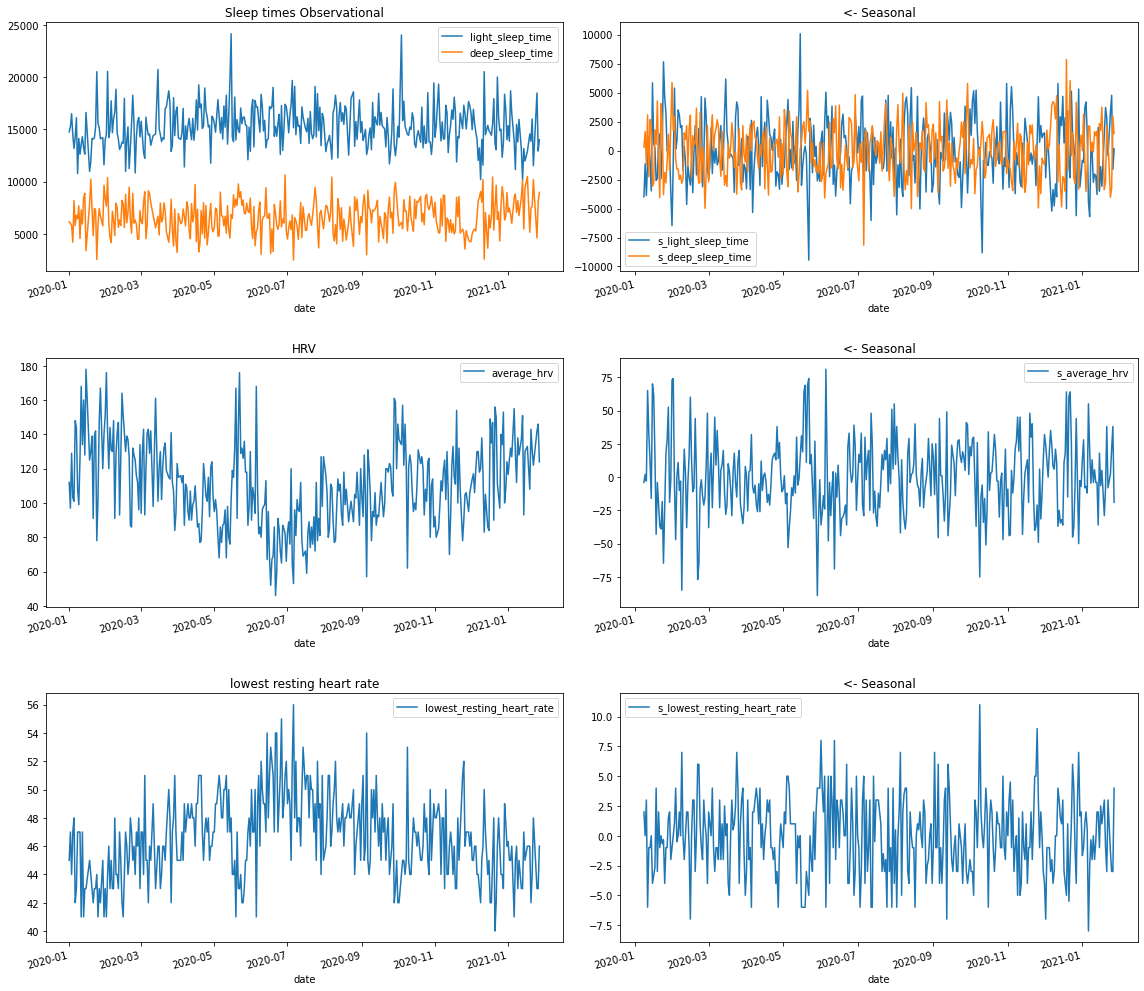

In [4]:
# --- 1.1 Eyeball Test

_, ax = plt.subplots(3, 2, figsize=(16, 14))
ax = ax.flatten()

df.plot(y=['light_sleep_time', 'deep_sleep_time'], title="Sleep times Observational", ax=ax[0]);
df.plot(y=['s_light_sleep_time', 's_deep_sleep_time'], title="<- Seasonal", ax=ax[1]);

df.plot(y="average_hrv", title="HRV", ax=ax[2]);
df.plot(y="s_average_hrv", title="<- Seasonal", ax=ax[3]);

df.plot(y="lowest_resting_heart_rate", title="lowest resting heart rate", ax=ax[4]);
df.plot(y="s_lowest_resting_heart_rate", title="<- Seasonal", ax=ax[5]);
_.tight_layout(h_pad=2)
[x.set_xticklabels(x.get_xticklabels(), rotation=15) for x in ax];

They all certainly look stationary. I would expect all of them to easily beat the $H_0$, but the sleep times to get extra tiny p values. I don't see any (weekly) seasonality at a glance, but that could be a resolution thing.
<a id="oadf"><a/>

In [5]:
# --- 1.2 Observations - Augmented Dicky Fuller Testing

from statsmodels.tsa.stattools import adfuller

results = {}
for col in variables_of_interest:
    result = adfuller(df[col])
    results[col] = dict(zip(['adf', 'pvalue', 'usedlag', 'nobs',
                             'critical' 'values', 'icbest'],result)
                       )
print(json.dumps(results, sort_keys=True, indent=4))

{
    "average_hrv": {
        "adf": -3.860719113148694,
        "criticalvalues": {
            "1%": -3.4473167281607155,
            "10%": -2.5707536074503134,
            "5%": -2.869018036958473
        },
        "icbest": 3281.830194262184,
        "nobs": 388,
        "pvalue": 0.002343723844541309,
        "usedlag": 4
    },
    "deep_sleep_time": {
        "adf": -6.717358160036419,
        "criticalvalues": {
            "1%": -3.4473167281607155,
            "10%": -2.5707536074503134,
            "5%": -2.869018036958473
        },
        "icbest": 6595.4462481317,
        "nobs": 388,
        "pvalue": 3.5540952253328055e-09,
        "usedlag": 4
    },
    "light_sleep_time": {
        "adf": -16.38292752415294,
        "criticalvalues": {
            "1%": -3.44714244478345,
            "10%": -2.5707127699396084,
            "5%": -2.8689414326247995
        },
        "icbest": 6761.279116220355,
        "nobs": 392,
        "pvalue": 2.740416783622128e-29,
      

For all timeseries, $p < 0.05$. we can reject the null hypothesis for all timeseries with $d = 0$.

All of the timeseries are stationary when viewed from the obsevational resolution
<a id="sadf"><a/>

In [6]:
# --- 1.3 Seasonal - Augmented Dicky Fuller Testing 

# In this case, I don't expect the seasonal stationarity tests 
# to yield roots so i'm just going to implement a simple loop

for col in variables_of_interest:
    pval = adfuller(df["s_{}".format(col)].dropna())[1]
    if pval < 0.05:
        print("{c} passes with pval {p}".format(c=col, p=pval))

deep_sleep_time passes with pval 1.480233405667031e-14
light_sleep_time passes with pval 9.352535154498334e-13
average_hrv passes with pval 1.283494707467697e-05
lowest_resting_heart_rate passes with pval 6.6796880311287135e-06


Thus $D = 0$ since no differencing at the seasonal resolution is required

___
### 2. Find p, P, q and Q to check for ACF and PACF <a id="acf-pacf"><a/>
___
    
##### - 2.1 ACF, PACF observational res via the Eyeballs
##### - 2.2 ACF, PACF seasonal res via the Eyeballs
 <a id="eyeball2"><a/>

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

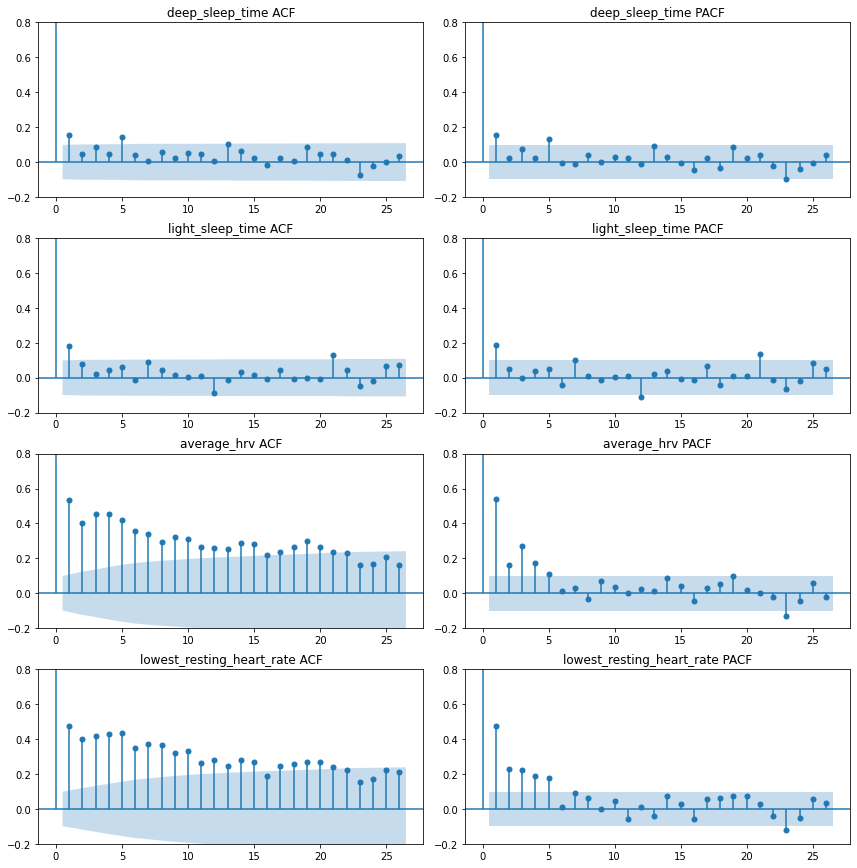

In [8]:
# --- 2.1 Observational Resolution via the Eyeballs

rows = len(variables_of_interest)
_, ax = plt.subplots(rows, 2, figsize=(12, 3 * rows))
ax = ax.flatten()
_.tight_layout(h_pad=2)

for i, col in enumerate(variables_of_interest):
    i = i+1 # pesky zero
    plot_acf(df[col], ax=ax[i * 2 - 2]);
    plot_pacf(df[col], ax=ax[i * 2 - 1]);
    ax[i * 2 - 2].set_title("{c} ACF".format(c=col))
    ax[i * 2 - 1].set_title("{c} PACF".format(c=col))
    ax[i * 2 - 2].set_ylim(-0.2, 0.8)
    ax[i * 2 - 1].set_ylim(-0.2, 0.8)

___
#### 2.1 Observational ACF, PACF
___

#### 2.1.1. Deep Sleep
ACF basically doesn't happen. It could be a factor in an analysis with more factors, but that's a story for another notebook.

For reasons that will become clear in the seasonal portion, I thought I may as well try a model for this one anyway.

$$
p = q = 0
$$

#### 2.1.2. Light Sleep
Same as deep sleep but I think i'll try going through with ARIMA on it just to see what happens.

Let's try the AR(1) model since theyre still positive

$$
1. \>\> p=1, q=0\\
2. \>\> p=1, q=1
$$

#### 2.1.3. HRV
ACF falls more or less gradually and PACF cuts off at 1.

This suggests we should start with a:

$$
1. \>\> p = 1, q = 0\\
2. \>\> p = 1, q = 1
$$

and maybe try a $p=3$ as well? maybe 4, just to see.

#### 2.1.4. Lowest resting heart rate
ACF falls gradually, PACF cuts off at 1... maybe 5?

$$
1. \>\> p= 1, q=0\\
2. \>\> p = 3, q = 0
$$

and we'll also try $p=5$ along side for fun.
<a id="eyeball3"><a/>

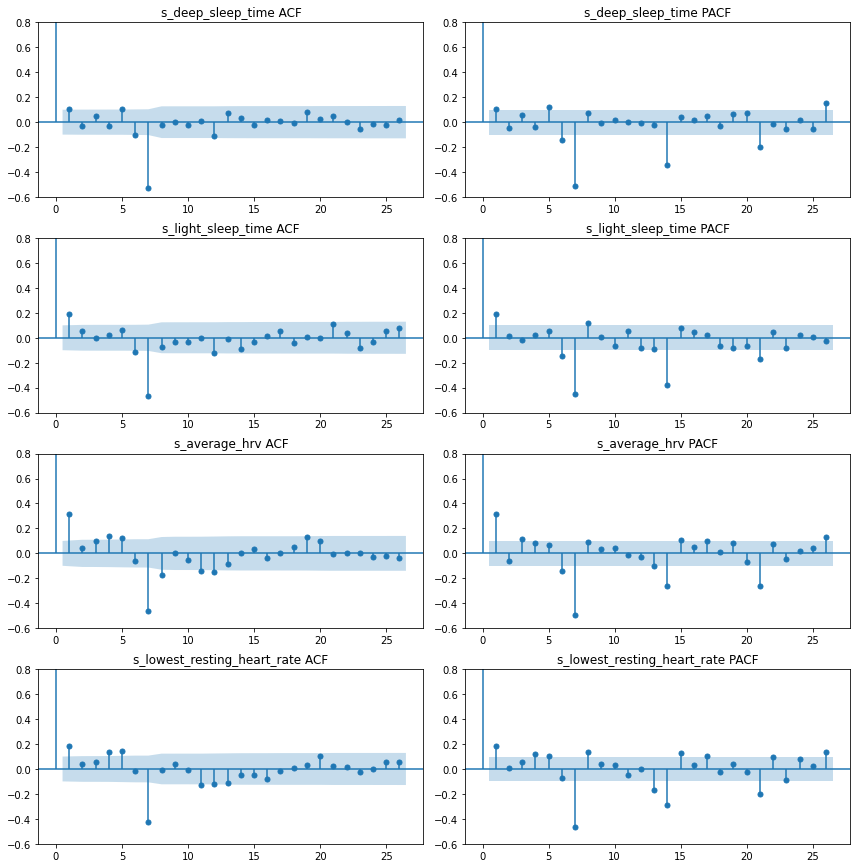

In [9]:
# --- 2.1 Seasonal Resolution via the Eyeballs

rows = len(variables_of_interest)
_, ax = plt.subplots(rows, 2, figsize=(12, 3 * rows))
ax = ax.flatten()
_.tight_layout(h_pad=2)

for i, col in enumerate(variables_of_interest):
    i = i+1 # pesky zero
    col = "s_" + col
    plot_acf(df[col].dropna(), ax=ax[i * 2 - 2]);
    plot_pacf(df[col].dropna(), ax=ax[i * 2 - 1]);
    ax[i * 2 - 2].set_title("{c} ACF".format(c=col))
    ax[i * 2 - 1].set_title("{c} PACF".format(c=col))
    ax[i * 2 - 2].set_ylim(-0.6, 0.8)
    ax[i * 2 - 1].set_ylim(-0.6, 0.8)

#### 2.2 Seasonal 
For all series, there's a significant negative spike at lag $m=7$ for the ACFs and at multiples of $m$ for the PACF. According to the arima bible, this means that we should consider set SMA term to 1. To do this, one must first know what a SMA term is, which I presently do not.

Found it, the S in SMA stands for seasonal - that is to say, choose:

$$
P = 0, Q = 1
$$

no P

___
### 3. Make ARIMA Models <a id="make-arima"></a>
___
#####  3.1 Build models
##### 3.2 Eyeball errors 
##### 3.3 Draw a forecast
##### 3.4 Try a running forecast, looking 1 week ahead

In [10]:
# --- 3.1 Build Models

d = 0 # = D
P = 0
Q = 1

from statsmodels.tsa.statespace.sarimax import SARIMAX

params = {
    "deep_sleep_time-0" : {
        "p" : 0,
        "q" : 0,
    },
    "light_sleep_time-0" : {
        "p" : 1,
        "q" : 0,
    },
    "light_sleep_time-1" : {
        "p" : 1,
        "q" : 1,
    },
    "average_hrv-0" : {
        "p" : 1,
        "q" : 0,
    },
    "average_hrv-1" : {
        "p" : 1,
        "q" : 1,
    },
    "lowest_resting_heart_rate-0" : {
        "p" : 1,
        "q" : 0,
    },
    "lowest_resting_heart_rate-1" : {
        "p" : 3,
        "q" : 0,
    },
}

Now, Apply models and draw residue kde.
<a id="eyeball-errors"><a/>

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g.

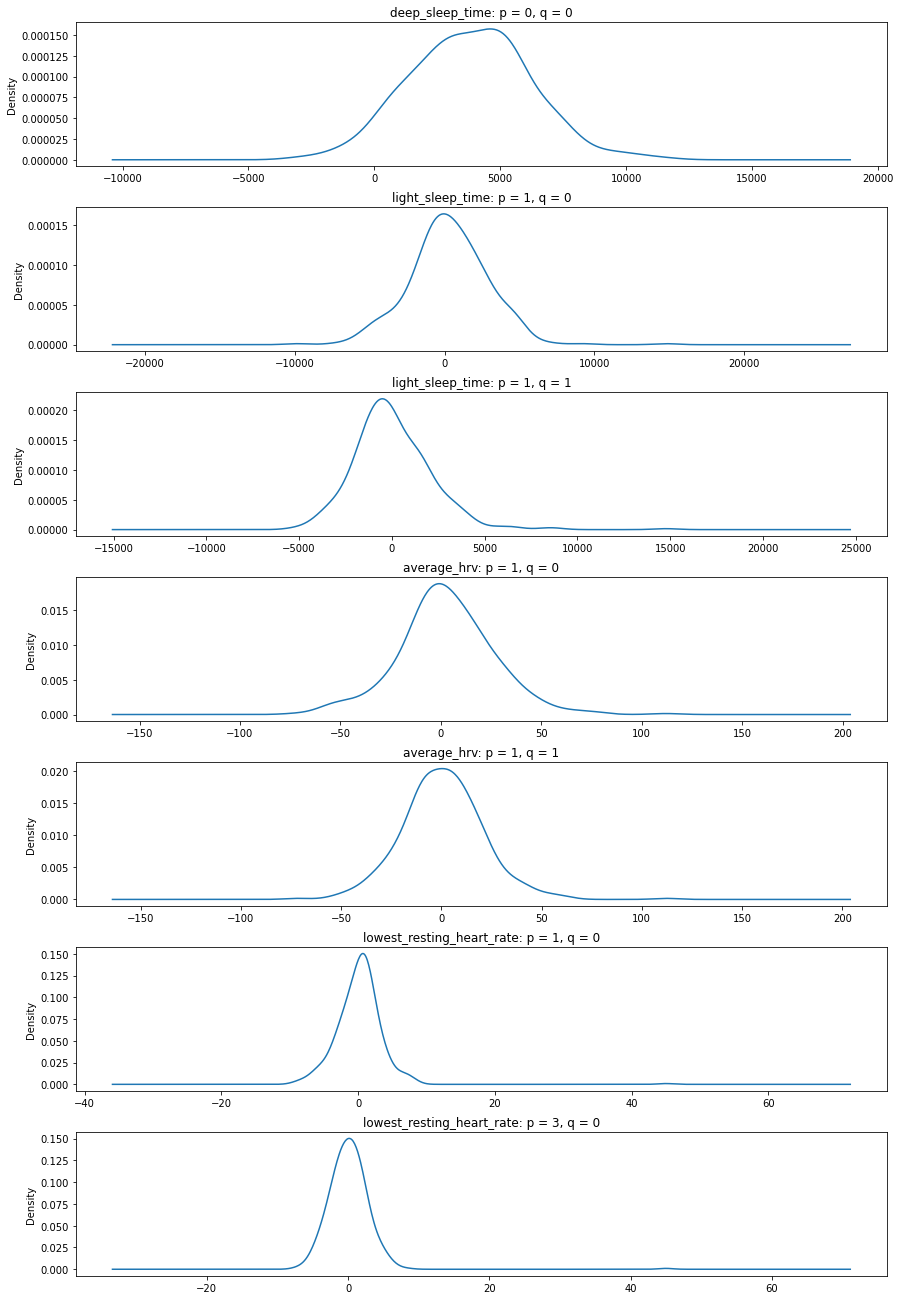

In [11]:
# --- 3.2 Eyeball Errors

nplots = len(params)

_, ax = plt.subplots(nplots, figsize=(12, 18))
ax = ax.flatten()
_.tight_layout(h_pad=2)

models = {}

for i, param in enumerate(params.items()):
    label, tuning = param

    var_name, exeriment_count = label.split("-")
    p = tuning['p']
    q = tuning['q']
    
    model = SARIMAX(
        df[var_name],
        order=(p, d, q),
        seasonal_order=(P, d, Q, m)
    )
    models[label] = model
    
    ax[i].set_title("{l}: p = {p}, q = {q}".format(l=var_name, p=p, q=q))
    model.fit().resid.plot(kind='kde', ax=ax[i])

Wow. I don't think i've ever yielded such a pretty normal from wild data...

As expected, the deep and light sleep KDEs don't look great. Totally unexpected, the HRV and lowest resting heart rates look incredible, to the point where it's a little suspicious. I guess the testing to come will check for any overfitting.

Out of curiosity, I wonder what it looks like to just plot it directly on top.

<a id="draw-forecast"><a/>

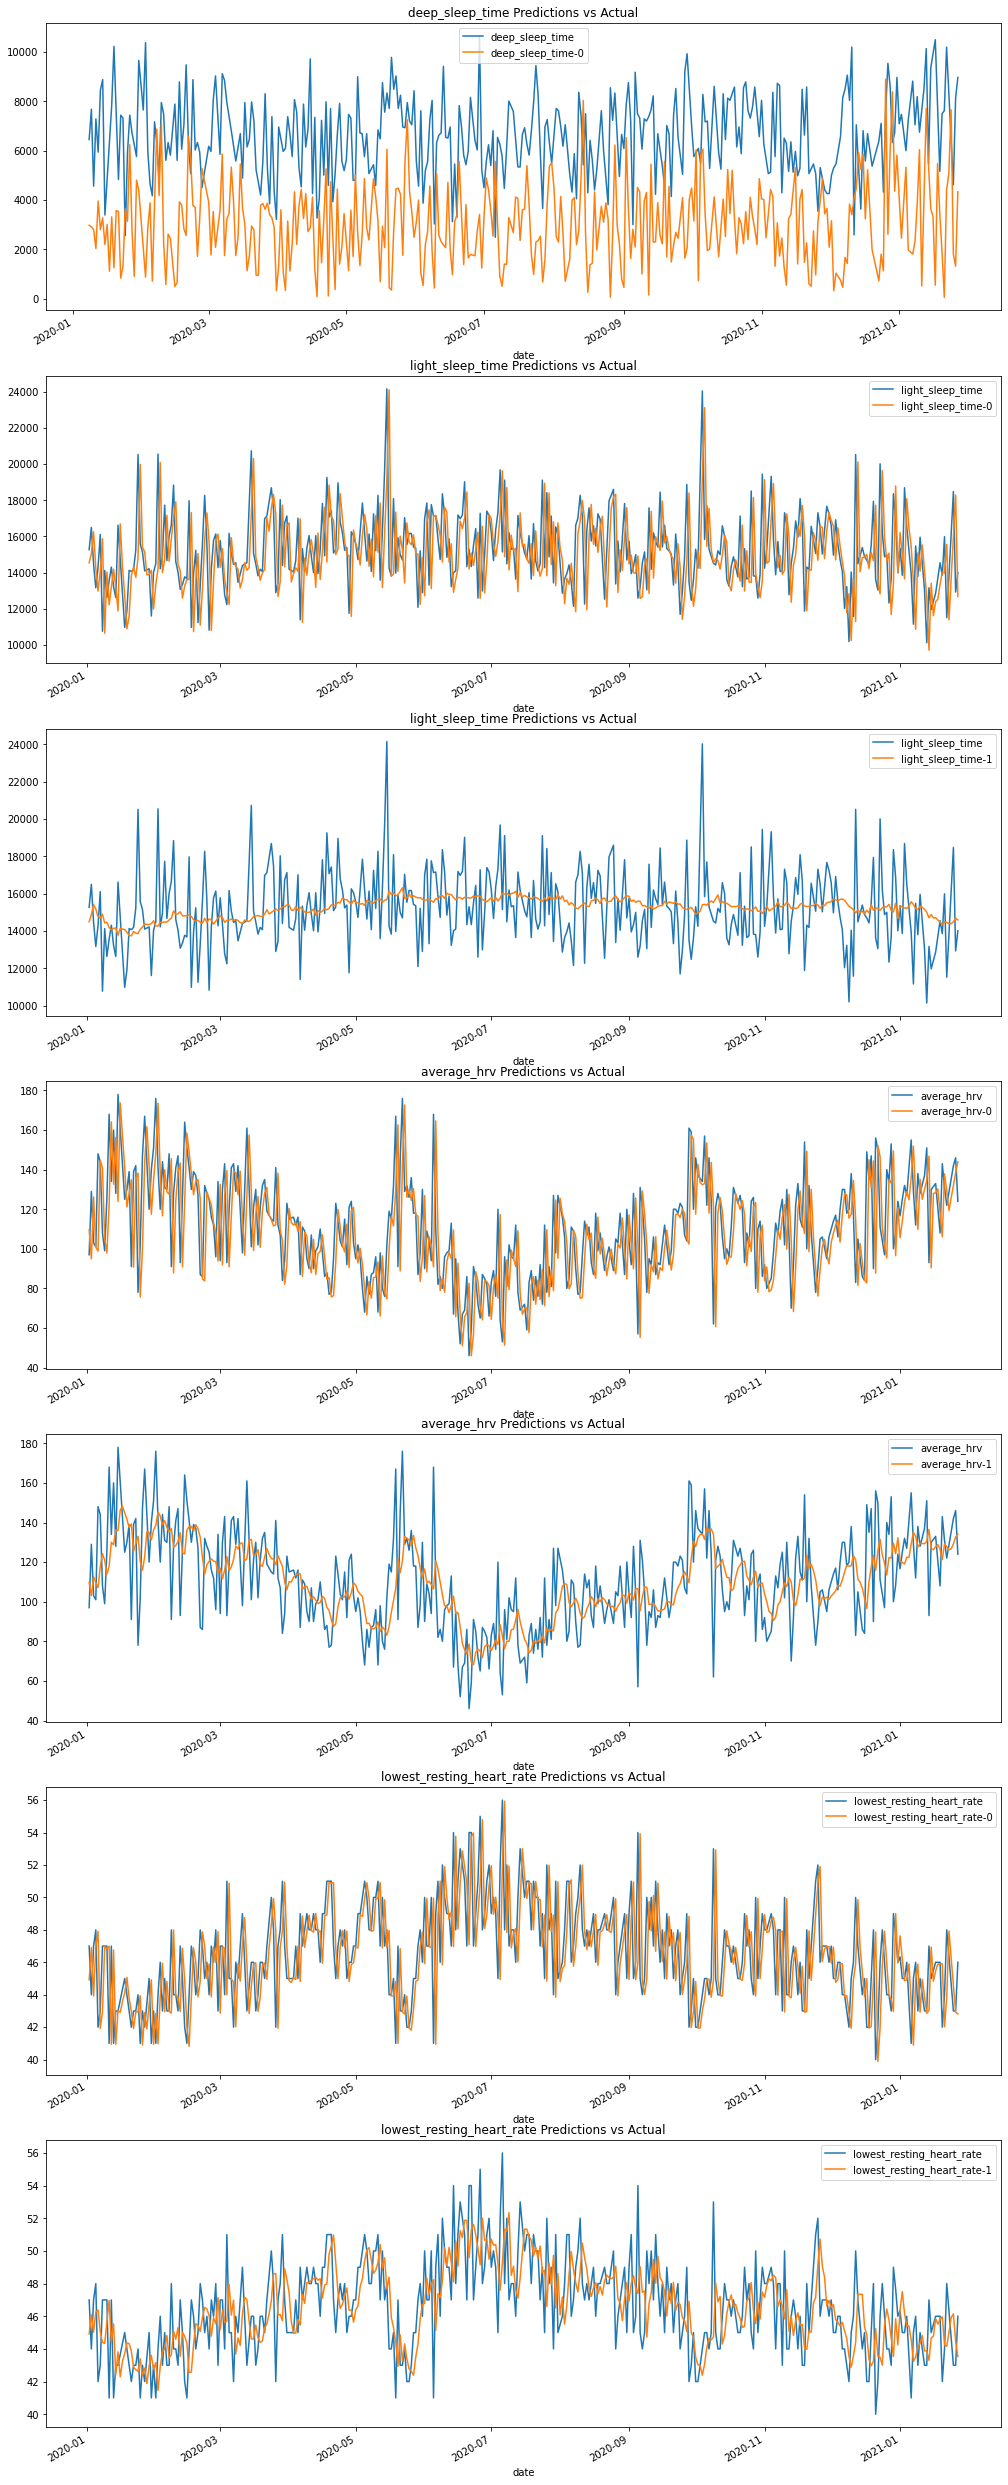

In [12]:
# --- 3.3 Draw a forecasts compared to the "training" data

_, ax = plt.subplots(nplots, figsize=(14, 6 * nplots))
ax = ax.flatten()
_.tight_layout(h_pad=6)

for i, m in enumerate(models.items()):
    var, tuning = m[0].split("-")
    model = m[1]
    fit = model.fit()
    model_v_data = pd.DataFrame(index=df.index, 
                                columns=[var, var + "-" + tuning]
                               )
    model_v_data[var] = df[var]
    model_v_data[var + "-" + tuning] = fit.predict()
    model_v_data = model_v_data.loc[model_v_data[var + "-" + tuning] > 1]
    
    ax[i].set_title("{v} Predictions vs Actual".format(v=var));
    model_v_data.plot(ax=ax[i]);

wow, well now I see why the distribution from earlier is so nice.

The final question is: How good is it at predicting values outside of the date range it was built on?

There's actually two questions here.

The less fair question is one of whether the parameters set above can make good, long term forecasts - The answer to this version of the question is almost certainly no but we have to see!

The much more interesting question is whether or not it can make decent rolling predictions. This is also the more sensible question: Whether or not it can make decent short-term predictions and maintain decentness by updating the parameters as each day's datapoint is added.

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is 

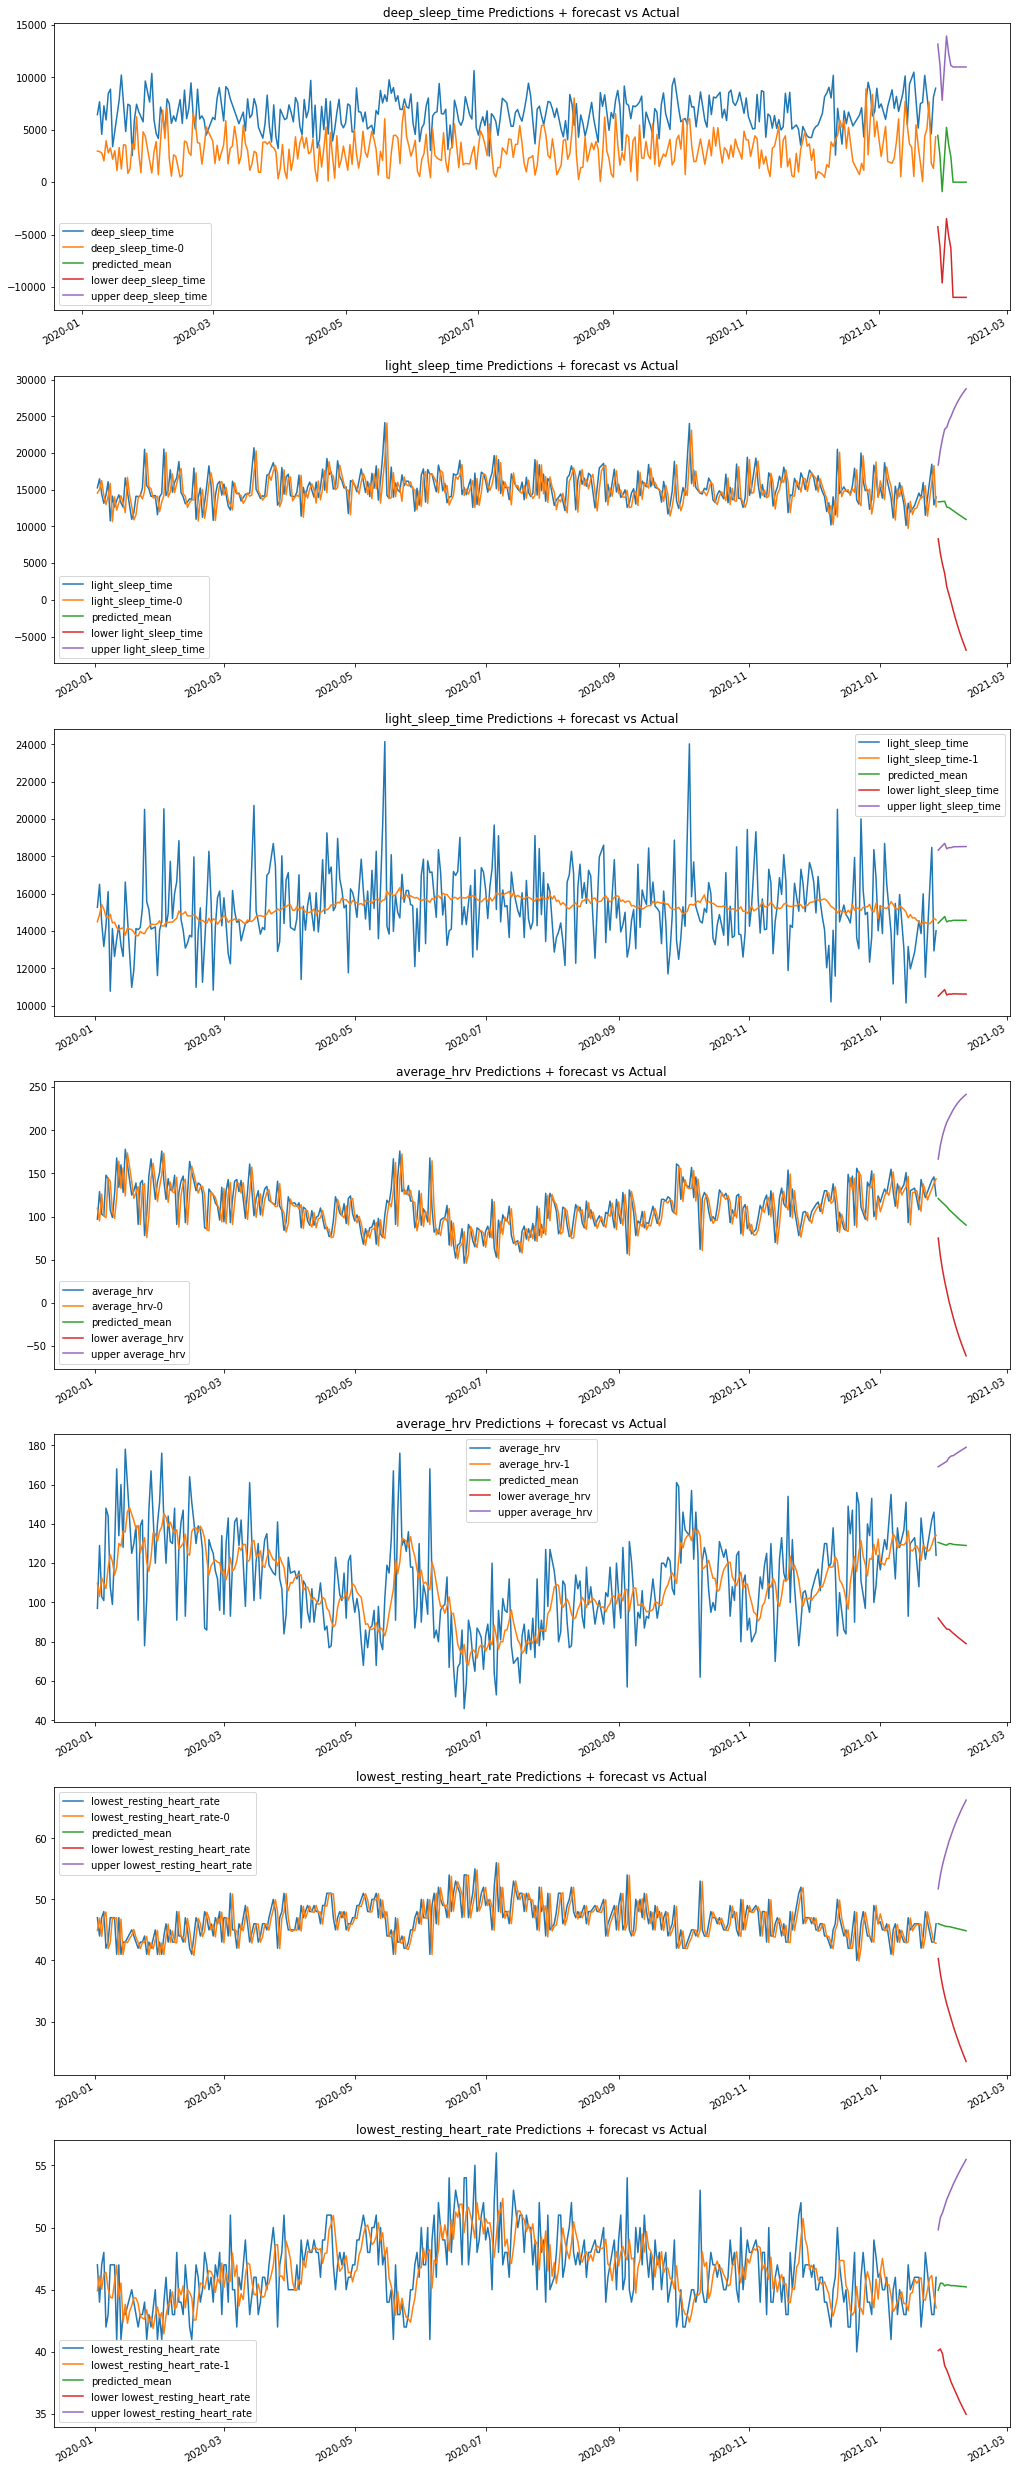

In [13]:
# --- Short Term Forecast (copy paste previous code but add forecast bit)

_, ax = plt.subplots(nplots, figsize=(14, 6 * nplots))
ax = ax.flatten()
_.tight_layout(h_pad=6)
DateOffset = pd.tseries.offsets.DateOffset

for i, m in enumerate(models.items()):
    var, tuning = m[0].split("-")
    model = m[1]
    fit = model.fit()
    model_v_data = pd.DataFrame(index=df.index, 
                                columns=[var, var + "-" + tuning]
                               )
    model_v_data[var] = df[var]
    model_v_data[var + "-" + tuning] = fit.predict()
    model_v_data = model_v_data.loc[model_v_data[var + "-" + tuning] > 1]
    
    # Forecast
    
    forecasts = fit.get_forecast(steps=14)
    forecast_mean = forecasts.predicted_mean
    confidence_interval = forecasts.conf_int()
    crystal_ball = pd.concat([forecast_mean, confidence_interval], axis=1)

    append_dates = [max(model_v_data.index)+DateOffset(days=x) for x in range(1,15)]
    
    crystal_ball = crystal_ball.rename(index=dict(zip(crystal_ball.index, append_dates)))
    
    final = pd.concat([model_v_data, crystal_ball], axis=0)
    
    # Plot
    
    ax[i].set_title("{v} Predictions + forecast vs Actual".format(v=var));
    final.plot(ax=ax[i]);

Those whiskers are not so confident. Theyre the 95% confidence bands.

In [14]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:           lowest_resting_heart_rate   No. Observations:                  393
Model:             SARIMAX(3, 0, 0)x(0, 0, [1], 7)   Log Likelihood                -917.979
Date:                             Fri, 21 May 2021   AIC                           1845.958
Time:                                     18:06:40   BIC                           1865.827
Sample:                                          0   HQIC                          1853.832
                                             - 393                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4256      0.044      9.713      0.000       0.340       0.511
ar.L2          0.2401      0.049      4.859      0.000       0.143       0.337
ar.L3          0.3336      0.045      7.372      0.000       0.245       0.422
ma.S.L7       -0.0014      0.055     -0.025      0.980      -0.108       0.106
sigma2         6.1570      0.433     14.205      0.000       5.307       7.006
===================================================================================
Ljung-Box (L1) (Q):                   2.87   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.09   Prob(JB):                         0.82
Heteroskedasticity (H):               1.11   Skew:                             0.07
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

___
### Further Steps <a id="further-steps"><a/>
___
